# Demonstration of Model Misspecification
Demonstrates model misspecification for the g-formula. Also highlights the benefit of flexible models

Data generating mechanism
$$L \sim N(10, 2)$$
$$C \sim B(0.384)$$
$$R \sim M(0.5, 0.3, 0.2)$$
$$W \sim 0.5L + 0.001L^2 - 3C + 5I(R=1) + \epsilon$$

$$A = expit(-3.2 + 0.454L + 2.1C + 1.3I(R=1) - 2.3W - 0.5C\times I(R=1) + 1.3W\times I(R=2))$$

$$Y = 50.3 - 10.4 A - 5.1 A \times C + I(L < 6.7)\left(\left(\frac{L - 10}{5}\right)^2 + 2\right) - 0.5 I(L \ge 6.7)L + 2.4 W - 0.03 W^2 - 5.1 I(R=1) - 20 I(R=2) - 3.1 I(R=1)\times W + 4 I(R=2) \times A \times C$$

Below is 1000 simulations of $n=600$, which the curse of dimensionality limits the flexibility we can have in the associated models

This data generating mechanism was originally created for a class I was a teaching assistant for. It is a particularly tricky mechanism because $L$ is part step-function and part continuous. This makes it difficult to model correctly (even for machine learning algorithms). The models I chose to include were a variety of potential models that students might try. Students used different flexible models that were fairly close to the truth (< 0.9 off) 

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import logistic
import matplotlib.pyplot as plt
%matplotlib inline

from zepid import spline
from zepid.causal.gformula import TimeFixedGFormula

In [2]:
# Global parameters
n = 600
sims = 2000
np.random.seed(252809532)

truth = -12.04989

In [3]:
# Containers for results
bias_truth = []
bias_crude = []
bias_main = []
bias_quad = []
bias_cubic = []
bias_compl = []
bias_spline = []
bias_inter = []
bias_sqint = []

In [4]:
# Generating background data
for s in range(sims):
    df = pd.DataFrame()
    df['L'] = np.random.normal(loc=10, scale=2, size=n)
    df['C'] = np.random.binomial(n=1, p=0.384, size=n)
    df[['R0', 'R1', 'R2']] = pd.DataFrame(np.random.multinomial(n=1, pvals=[0.5, 0.3, 0.2], size=n))
    df['R'] = np.where(df['R0'] == 1, 0, np.nan)
    df['R'] = np.where(df['R1'] == 1, 1, df['R'])
    df['R'] = np.where(df['R2'] == 1, 2, df['R'])
    df['W'] = 0.5*df['L'] + 0.001*df['L']*df['L'] - 3*df['C'] + 5*df['R1'] + np.random.normal(size=n)

    # Generating treatment assignment mechanism
    df['A'] = np.random.binomial(1,
                                 p=logistic.cdf(-3.2 + 0.454*df['L'] + 2.1*df['C'] + 1.3*df['R1'] - 2.3*df['W'] -
                                                0.5*df['C']*df['R1'] + 1.3*df['W']*df['R2']),
                                 size=n)

    # Generating counterfactuals
    df['Ya1'] = (50.3 - 10.4*1 - 5.1*1*df['C'] + np.where(df['L'] < 6.7, 1, 0)*(((df['L'] - 10)/5)**2 + 2) -
                 0.5*np.where(df['L'] >= 6.7, 1, 0)*df['L'] + 2.4*df['W'] - 0.03*df['W']*df['W']
                 - 5.1*df['R1'] - 20*df['R2'] - 3.1*df['R1']*df['W'] + 4*1*df['C']*df['R2']
                 + np.random.normal(size=n))
    df['Ya0'] = (50.3 - 10.4*0 - 5.1*0*df['C'] + np.where(df['L'] < 6.7, 1, 0)*(((df['L'] - 10)/5)**2 + 2) -
                 0.5*np.where(df['L'] >= 6.7, 1, 0)*df['L'] + 2.4*df['W'] - 0.03*df['W']*df['W']
                 - 5.1*df['R1'] - 20*df['R2'] - 3.1*df['R1']*df['W'] + 4*0*df['C']*df['R2']
                 + np.random.normal(size=n))
    df['Y'] = df['A']*df['Ya1'] + df['Ya0']*(1-df['A'])


    # True specification
    df['W_sq'] = df['W']**2
    df['L_le'] = np.where(df['L'] < 6.7, 1, 0)*(((df['L'] - 10)/5)**2 + 2)
    df['L_up'] = np.where(df['L'] >= 6.7, 1, 0)*df['L']
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + A:C + L_le + L_up + W + W_sq + R1 + R2 + R1:W + R2:C:A', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_truth.append(r1 - r0 - truth)

    # Crude Model
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_crude.append(r1 - r0 - truth)

    # Main-Effects Model
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + C + W + L + R1 + R2', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_main.append(r1 - r0 - truth)

    # Quadratic
    df['W_sq'] = df['W']**2
    df['L_sq'] = df['L']**2
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + R1 + R2 + C + W + W_sq + L + L_sq', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_quad.append(r1 - r0 - truth)

    # Cubic
    df['W_cu'] = df['W']**3
    df['L_cu'] = df['L']**3
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + R1 + R2 + C + W + W_sq + W_cu + L + L_sq + L_cu', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_cubic.append(r1 - r0 - truth)

    df[['L_rs1', 'L_rs2', 'L_rs3']] = spline(df, var='L', term=3, n_knots=4, restricted=True)
    df[['W_rs1', 'W_rs2', 'W_rs3']] = spline(df, var='W', term=3, n_knots=4, restricted=True)

    # The Splines
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + C + W + W_rs1 + W_rs2 + W_rs3 + '
                           'L + L_rs1 + L_rs2 + L_rs3 + R1 + R2', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_spline.append(r1 - r0 - truth)

    # The Interactor Model
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + C + W + L + R1 + R2 + A:C + A:W + A:L + A:R1 + A:R2', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_inter.append(r1 - r0 - truth)

    # The Square-Interactor Model
    gf = TimeFixedGFormula(df, exposure='A', outcome='Y', outcome_type='normal')
    gf.outcome_model(model='A + C + W + W_sq + L + L_sq + R1 + R2 + A:C + A:R1 + A:R2 + A:W + A:W_sq + A:L +''
                     'A:L_sq', print_results=False)
    gf.fit(treatment='all')
    r1 = gf.marginal_outcome
    gf.fit(treatment='none')
    r0 = gf.marginal_outcome
    bias_sqint.append(r1 - r0 - truth)


## True outcome model
Results for the correctly specified g-formula outcome model

Bias: 0.10878081168457855
ESE: 0.5991897515453527


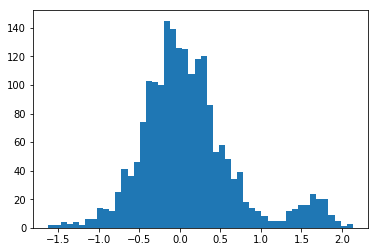

In [5]:
print('Bias:', np.mean(bias_truth))
print('ESE:', np.std(bias_truth, ddof=1))

plt.hist(bias_truth, bins=50)
plt.show()

## Crude model
Outcome model assumes that treatment was randomly assigned
$$Y = A$$

Bias: -6.215899292264532
ESE: 0.9994403491926713


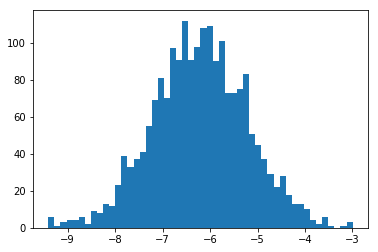

In [6]:
print('Bias:', np.mean(bias_crude))
print('ESE:', np.std(bias_crude, ddof=1))

plt.hist(bias_crude, bins=50)
plt.show()

## Main-effects model
Outcome model that only includes the main effects
$$Y = A + C + W + L + R_1 + R_2$$

Bias: -6.423121264762753
ESE: 0.6012625450177383


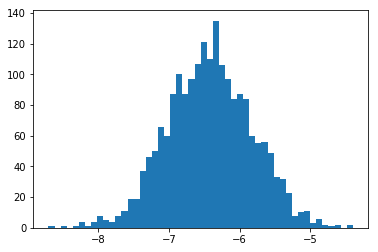

In [7]:
print('Bias:', np.mean(bias_main))
print('ESE:', np.std(bias_main, ddof=1))

plt.hist(bias_main, bins=50)
plt.show()

## Quadratic model
Outcome model that includes all confounders and quadratic terms for continuous variables
$$Y = A + R_1 + R_2 + C + W + W^2 + L + L^2$$

Bias: -0.9009706961769193
ESE: 0.37351032146408475


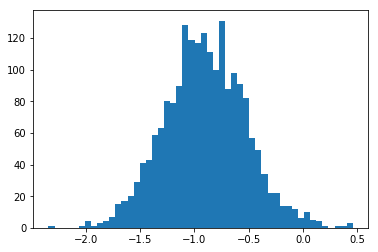

In [8]:
print('Bias:', np.mean(bias_quad))
print('ESE:', np.std(bias_quad, ddof=1))

plt.hist(bias_quad, bins=50)
plt.show()

## Cubic model
Model including cubic terms for continuous variables
$$Y = A + R_1 + R_2 + C + W + W^2 + W^3 + L + L^2 + L^3$$

Bias: -1.261056097131276
ESE: 0.3653616711431794


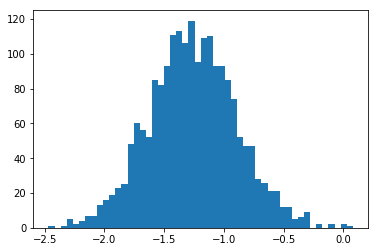

In [9]:
print('Bias:', np.mean(bias_cubic))
print('ESE:', np.std(bias_cubic, ddof=1))

plt.hist(bias_cubic, bins=50)
plt.show()

## Restricted cubic spline model
Model including restricted cubic spline terms for continuous variables
$$Y = A + C + W + g(W) + L + g(L) + R_1 + R_2$$

Bias: -1.4122900092488717
ESE: 0.3336099467288711


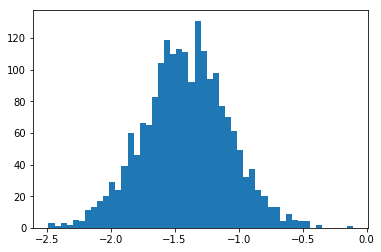

In [10]:
print('Bias:', np.mean(bias_spline))
print('ESE:', np.std(bias_spline, ddof=1))

plt.hist(bias_spline, bins=50)
plt.show()

## Interaction model
Model including treatment interactions with all variables
$$Y = A + C + W + L + R_1 + R_2 + AC + AW + AL + AR_1 + AR_2$$

Bias: 0.35544312313869897
ESE: 1.8789248052235366


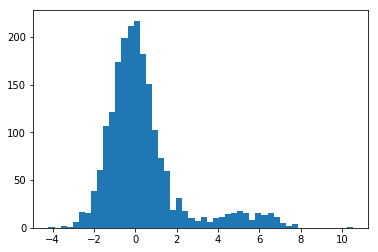

In [11]:
print('Bias:', np.mean(bias_inter))
print('ESE:', np.std(bias_inter, ddof=1))

plt.hist(bias_inter, bins=50)
plt.show()

## Square interaction model
Model including square terms and treatment interactions with all variables
$$Y = A + C + W + W^2 + L + L^2 + R_1 + R_2 + AC + AR_1 + AR_2$$

Bias: 0.14308522977383512
ESE: 2.214599561143243


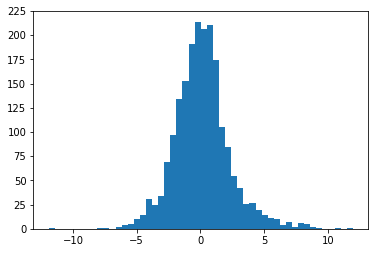

In [12]:
print('Bias:', np.mean(bias_sqint))
print('ESE:', np.std(bias_sqint, ddof=1))

plt.hist(bias_sqint, bins=50)
plt.show()